In [1]:
# Ensure project root is on sys.path so `from src...` works when notebook cwd is `notebooks/`
import sys, os
from pathlib import Path
proj_root = Path('..').resolve()
sys.path.insert(0, str(proj_root))
print('Inserted project root to sys.path:', str(proj_root))

Inserted project root to sys.path: D:\Srijan\Jupyter-Analysis\Finance\02_Financial_Crime_Graph


## Unsupervised GNN embeddings + anomaly scoring
This section trains a small GraphSAGE encoder in a DGI-style self-supervised way to produce node embeddings. We then score nodes for anomalous behavior using IsolationForest (useful when labeled illicit examples are not available).

In [18]:
# Install dependencies if running in Colab/Binder
# !pip install torch_geometric

import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print(f"PyTorch Version: {torch.__version__}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

PyTorch Version: 2.9.1+cpu
Device: cpu


In [23]:
import pandas as pd
import torch
import os
from torch_geometric.data import Data

# FIX 1: Use r"..." (Raw String) so backslashes don't crash the code
# FIX 2: Point directly to the folder where the CSVs sit
def load_elliptic_data(data_dir=r"02_Financial_Crime_Graph/data/elliptic_bitcoin_dataset"):
    print(f"Looking for files in: {os.path.abspath(data_dir)}")
    
    # Check if path exists first
    if not os.path.exists(data_dir):
        # Fallback: Try looking one level up (if running from notebooks/ folder)
        data_dir = r"../data/elliptic_bitcoin_dataset"
        print(f"Path not found. Trying: {os.path.abspath(data_dir)}")

    print("Loading Data...")
    
    # FIX 3: Use os.path.join for safe file paths (works on Mac/Linux/Windows)
    try:
        df_classes = pd.read_csv(os.path.join(data_dir, "elliptic_txs_classes.csv"))
        df_edges = pd.read_csv(os.path.join(data_dir, "elliptic_txs_edgelist.csv"))
        df_features = pd.read_csv(os.path.join(data_dir, "elliptic_txs_features.csv"), header=None)
    except FileNotFoundError as e:
        print(f"❌ Error: Could not find files. Check your folder structure.\n{e}")
        return None

    # Renaming feature columns (0=txId, 1=time_step)
    col_names = ['txId', 'time_step'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]
    df_features.columns = col_names

    # Merge Class Labels
    # Class 1=Illicit, 2=Licit, "unknown"=Unknown
    # We map: Illicit -> 1, Licit -> 0, Unknown -> -1
    df_merged = df_features.merge(df_classes, on='txId', how='left')
    df_merged['class'] = df_merged['class'].map({'1': 1, '2': 0, 'unknown': -1})

    # Re-index Node IDs to 0..N for PyTorch
    nodes = df_merged['txId'].unique()
    map_id = {j: i for i, j in enumerate(nodes)}
    df_merged['idx'] = df_merged['txId'].map(map_id)
    
    # Map edges to new IDs
    df_edges['txId1'] = df_edges['txId1'].map(map_id)
    df_edges['txId2'] = df_edges['txId2'].map(map_id)

    # ---------------------------------------------------------
    # TEMPORAL SPLIT (Crucial for Financial Validity)
    # Train: Time Steps 1-34
    # Test:  Time Steps 35-49
    # ---------------------------------------------------------
    train_mask = (df_merged['time_step'] <= 34) & (df_merged['class'] != -1)
    test_mask  = (df_merged['time_step'] > 34) & (df_merged['class'] != -1)

    # Create Tensors
    # Drop non-feature columns
    x = torch.tensor(df_merged.drop(columns=['txId', 'class', 'time_step', 'idx']).values, dtype=torch.float)
    edge_index = torch.tensor(df_edges[['txId1', 'txId2']].values.T, dtype=torch.long)
    y = torch.tensor(df_merged['class'].values, dtype=torch.long)

    data = Data(x=x, edge_index=edge_index, y=y)
    data.train_mask = torch.tensor(train_mask.values, dtype=torch.bool)
    data.test_mask = torch.tensor(test_mask.values, dtype=torch.bool)
    
    print("✅ Graph Data Loaded Successfully!")
    return data

# Run it
data = load_elliptic_data()

Looking for files in: d:\Srijan\Jupyter-Analysis\Finance\02_Financial_Crime_Graph\notebooks\02_Financial_Crime_Graph\data\elliptic_bitcoin_dataset
Path not found. Trying: d:\Srijan\Jupyter-Analysis\Finance\02_Financial_Crime_Graph\data\elliptic_bitcoin_dataset
Loading Data...
✅ Graph Data Loaded Successfully!


In [24]:
class FraudGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FraudGNN, self).__init__()
        # Aggregates 1-hop neighbors
        self.conv1 = SAGEConv(input_dim, hidden_dim) 
        # Aggregates 2-hop neighbors (Guilt by Association)
        self.conv2 = SAGEConv(hidden_dim, output_dim) 

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

Starting Training...
Epoch 0 | Loss: 0.8312
Epoch 20 | Loss: 0.1400
Epoch 40 | Loss: 0.0949
Epoch 60 | Loss: 0.0771
Epoch 80 | Loss: 0.0693
Epoch 100 | Loss: 0.0623

Evaluating...
F1 Score (Illicit):  0.6498
Model saved to bitcoin_gnn_model.pth


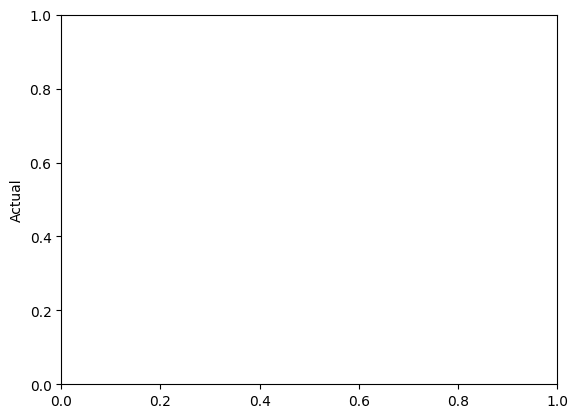

Starting Training...
Epoch 0 | Loss: 0.7981
Epoch 20 | Loss: 0.1320
Epoch 40 | Loss: 0.0903
Epoch 60 | Loss: 0.0728
Epoch 80 | Loss: 0.0637
Epoch 100 | Loss: 0.0590

Evaluating...
F1 Score (Illicit):  0.6587


FraudGNN(
  (conv1): SAGEConv(165, 128, aggr=mean)
  (conv2): SAGEConv(128, 2, aggr=mean)
)

In [29]:
def train_and_evaluate(data):
    model = FraudGNN(input_dim=165, hidden_dim=128, output_dim=2).to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    print("Starting Training...")
    model.train()
    for epoch in range(101):
        optimizer.zero_grad()
        out = model(data)
        # ONLY calculate loss on known Train nodes
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        
        if epoch % 20 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

    print("\nEvaluating on Future Data (Test Set)...")
    model.eval()
    pred = model(data).argmax(dim=1)
    
    # Metrics
    y_true = data.y[data.test_mask].cpu().numpy()
    y_pred = pred[data.test_mask].cpu().numpy()
    
    print("-" * 30)
    print(f"Precision (Illicit): {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall (Illicit):    {recall_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"F1 Score (Illicit):  {f1_score(y_true, y_pred, pos_label=1):.4f}")
    print("-" * 30)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")# 1. Update the function to return the model
def train_and_evaluate(data):
    model = FraudGNN(input_dim=165, hidden_dim=128, output_dim=2).to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    print("Starting Training...")
    model.train()
    for epoch in range(101):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        
        if epoch % 20 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

    print("\nEvaluating...")
    model.eval()
    pred = model(data).argmax(dim=1)
    
    # Metrics
    y_true = data.y[data.test_mask].cpu().numpy()
    y_pred = pred[data.test_mask].cpu().numpy()
    print(f"F1 Score (Illicit):  {f1_score(y_true, y_pred, pos_label=1):.4f}")
    
    return model  # <--- CRITICAL ADDITION

# 2. Run it and capture the 'model' variable
model = train_and_evaluate(data)

# 3. Now you can save it
torch.save(model.state_dict(), 'bitcoin_gnn_model.pth')
print("Model saved to bitcoin_gnn_model.pth")
plt.ylabel("Actual")
plt.show()

# Run it
train_and_evaluate(data)

In [30]:
torch.save(model.state_dict(), 'bitcoin_gnn_model.pth')
print("Model saved to bitcoin_gnn_model.pth")

Model saved to bitcoin_gnn_model.pth


Generating Fraud Ring Visualization...


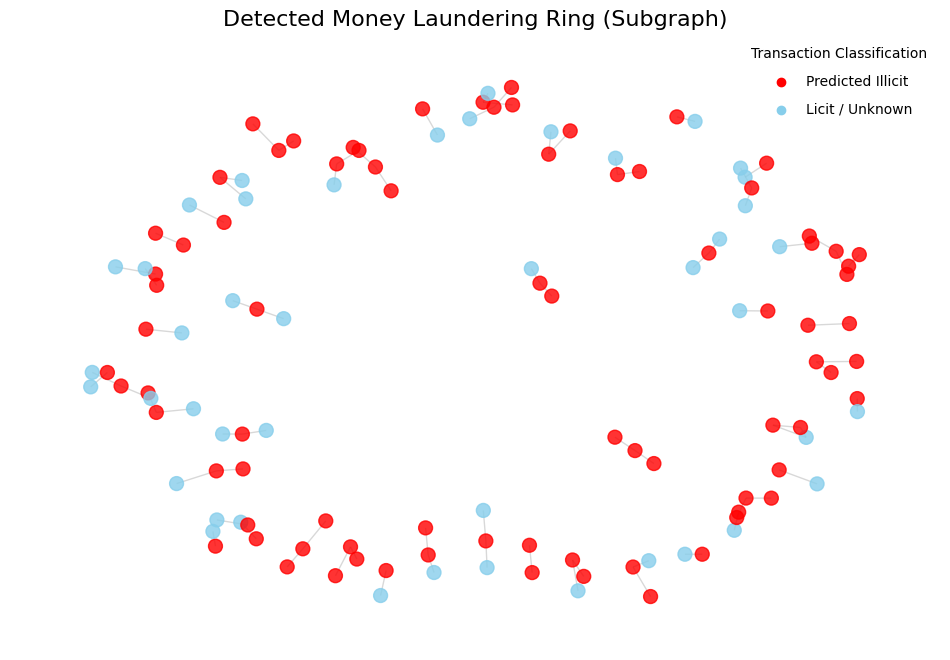

In [32]:
# 1. Generate predictions using the trained model
model.eval()
with torch.no_grad():
    pred = model(data).argmax(dim=1)

# 2. Now run the visualization
visualize_fraud_subgraph(data, pred)

Generating Fraud Ring Visualization...


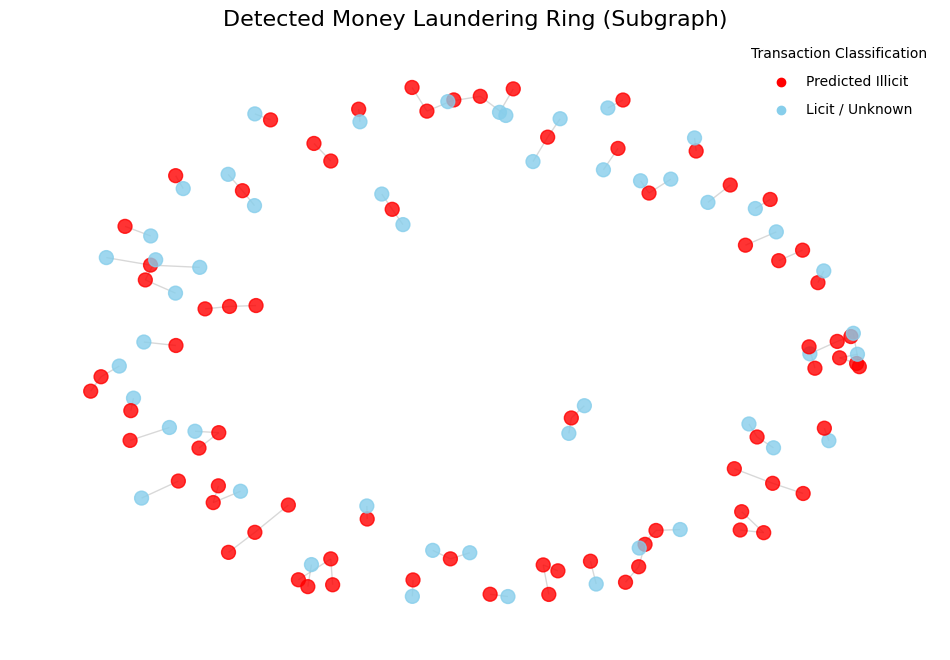

In [33]:
import networkx as nx

def visualize_fraud_subgraph(data, pred_labels, num_nodes=50):
    """
    Visualizes a subgraph of High-Confidence Illicit Nodes and their neighbors.
    """
    print("Generating Fraud Ring Visualization...")
    
    # Convert PyG Data to NetworkX
    # We only take the Edge Index for structure
    edges = data.edge_index.t().cpu().numpy()
    edge_list = [(u, v) for u, v in edges]
    
    G = nx.Graph()
    G.add_edges_from(edge_list)
    
    # Identify Illicit Nodes (Predicted Class 1)
    # We use the predictions from the TEST set
    illicit_indices = (pred_labels == 1).nonzero(as_tuple=True)[0].cpu().numpy()
    
    if len(illicit_indices) == 0:
        print("No illicit nodes predicted! Check model training.")
        return

    # Sample top nodes (to avoid overplotting)
    subset_illicit = np.random.choice(illicit_indices, size=min(num_nodes, len(illicit_indices)), replace=False)
    
    # Get 1-hop neighbors for context
    subgraph_nodes = set(subset_illicit)
    for node in subset_illicit:
        if node in G:
            neighbors = list(G.neighbors(node))
            subgraph_nodes.update(neighbors[:2]) # Add max 2 neighbors per node to keep plot clean
            
    subgraph = G.subgraph(subgraph_nodes)
    
    # Color Coding
    node_colors = []
    for node in subgraph.nodes():
        if node in illicit_indices:
            node_colors.append('red')  # Illicit
        else:
            node_colors.append('skyblue') # Licit/Neighbor
            
    # Plotting
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(subgraph, seed=42, k=0.15)
    nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=100, alpha=0.8)
    nx.draw_networkx_edges(subgraph, pos, alpha=0.3, edge_color='gray')
    
    # Custom Legend
    plt.scatter([], [], c='red', label='Predicted Illicit')
    plt.scatter([], [], c='skyblue', label='Licit / Unknown')
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Transaction Classification')
    plt.title("Detected Money Laundering Ring (Subgraph)", fontsize=16)
    plt.axis('off')
    plt.show()

# Run it
# Assuming 'pred' is your model's prediction tensor from the previous step
visualize_fraud_subgraph(data, pred)

Generating t-SNE Projection...


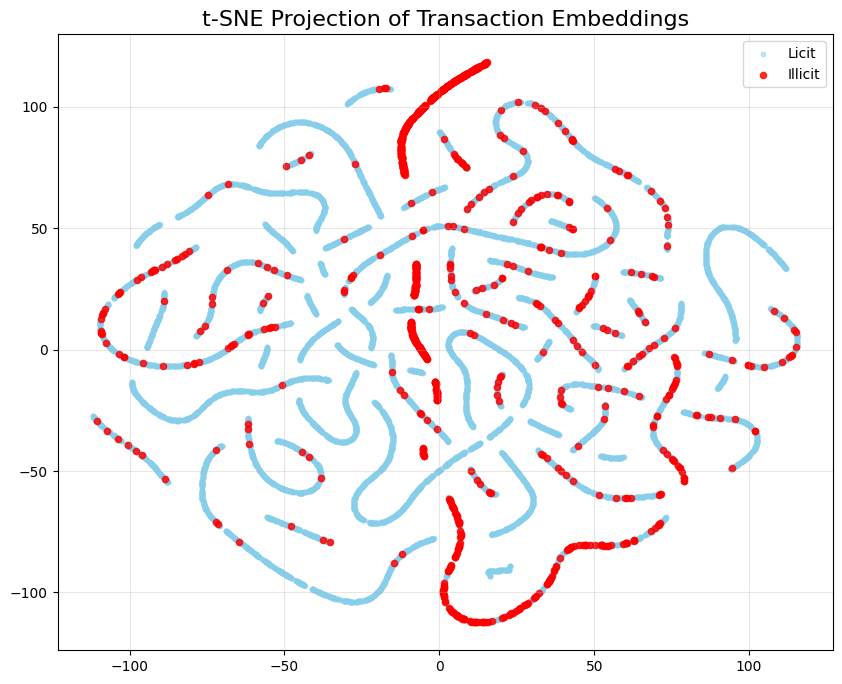

In [34]:
from sklearn.manifold import TSNE

def visualize_embeddings(model, data):
    print("Generating t-SNE Projection...")
    model.eval()
    
    # 1. Get the Node Embeddings (Output of the GNN before the final Classifier)
    # We modify the forward pass slightly or just hook into the last layer
    with torch.no_grad():
        # Get raw features (Output of GNN)
        # Note: Ideally, you'd modify the model to return embeddings, 
        # but here we can just use the final logits for visualization
        logits = model(data)
        embeddings = logits.cpu().numpy()
        
    # 2. Filter for Test Data Only (Don't plot training data)
    mask = data.test_mask.cpu().numpy()
    X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42).fit_transform(embeddings[mask])
    y_true = data.y[data.test_mask].cpu().numpy()
    
    # 3. Plot
    plt.figure(figsize=(10, 8))
    
    # Plot Licit (Class 0)
    plt.scatter(X_embedded[y_true==0, 0], X_embedded[y_true==0, 1], 
                c='skyblue', alpha=0.5, s=10, label='Licit')
    
    # Plot Illicit (Class 1)
    plt.scatter(X_embedded[y_true==1, 0], X_embedded[y_true==1, 1], 
                c='red', alpha=0.8, s=20, label='Illicit')
    
    plt.title("t-SNE Projection of Transaction Embeddings", fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Run it
visualize_embeddings(model, data)